In [1]:
import sys
sys.path.insert(1, '../scripts')

In [5]:
# data processing
import pandas as pd
from Bio import AlignIO
import alignment_quality as aq
import crutil

# logistic regression model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
states = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

## Functions

In [6]:
def get_aa_freq(seq, aa):
    cnt = 0
    for i in seq:
        if i == aa:
            cnt += 1
    aa_freq = cnt / len(seq)
    return aa_freq

In [7]:
def append_percent_aa(row, aa):
    seq = row['region_seq']
    if len(seq) == 0:
        print(row['uni_id'])
    return get_aa_freq(seq, aa)

## Training logistic regression model using AlphaFold data

In [8]:
df = pd.read_csv('../../data/af_regions/sc_af_regions_all.csv')

In [9]:
for aa in states:
    df['freq_'+aa] = df.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [10]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X = df[featurecol]
y = df['label']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logreg = LogisticRegression()
logreg.fit(X, y)

LogisticRegression()

## Conservation of labels in highly charged regions

In [11]:
df_hc = pd.read_csv('../../data/charged_regions/cr_filtered_aflabel.csv')

In [12]:
fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
wrong_seq = []
for index, row in df_hc.iterrows():
    orf = row['orf']
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    contains_seq = False
    for record in msa:
        seq = crutil.remove_gaps(record.seq)
        if row['region.seq'] in seq:
            contains_seq = True
    if not contains_seq:
        wrong_seq.append(index)

In [13]:
df_hc.drop(df_hc.index[wrong_seq], inplace=True)

In [14]:
def append_percent_aa(row, aa):
    seq = row['seq']
    return get_aa_freq(seq, aa)

In [36]:
def append_structure_conservation(row):
    fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
    orf = row['orf']  
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    sc_label = row['label']
    
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    if len(msa) >= 15:
        region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
        tmpdf = pd.DataFrame(columns=['seq', 'is_sc'])
        for seq in region_msa:
            s = crutil.remove_gaps(seq.seq)
            name = seq.id
            if len(s) >= 25 and name != 'Saccharomyces':
                tmpdf = tmpdf.append({'seq': s, 'is_sc': 0}, ignore_index=True)
            elif refseq in s and name == 'Saccharomyces':
                tmpdf = tmpdf.append({'seq': refseq, 'is_sc': 1}, ignore_index=True)
        if len(tmpdf) >= 15 and len(tmpdf[tmpdf.is_sc == 1]) >= 1:
            for aa in states:
                tmpdf['freq_'+aa] = tmpdf.apply(lambda r: append_percent_aa(r, aa), axis=1)
            featurecol = []
            for aa in states:
                featurecol.append('freq_'+aa)
            X = tmpdf[featurecol]
            y = logreg.predict(X).tolist()
            return max(y.count('disordered'), y.count('helix')) / len(y)
        elif len(tmpdf[tmpdf.is_sc == 1]) == 0:
            print(orf)
    else:
        return None

In [37]:
df_hc['cons'] = df_hc.apply(lambda row: append_structure_conservation(row), axis=1)

In [46]:
len(df_hc[df_hc.cons >= 0.8]) / len(df_hc)

0.6002554278416348

## Conservation of secondary structure in randomly selected regions

In [23]:
df_random = pd.read_csv('../../data/af_regions/random_af_regions_low_thresh.csv')

In [24]:
with open('../../data/misc/uniprot-to-sgdid.txt') as f:
    mappings = {}
    for line in f:
        uniprot = line[95:106].rstrip()
        orf = line[75:95].rstrip()
        mappings[uniprot] = orf

In [25]:
fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
bad_seq = []
for index, row in df_random.iterrows():
    orf = mappings[row['uni_id']]
    try:
        msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
        contains_seq = False
        for record in msa:
            seq = crutil.remove_gaps(record.seq)
            if row['seq'] in seq:
                contains_seq = True
        if not contains_seq:
            bad_seq.append(index)
    except:
        bad_seq.append(index)

In [26]:
df_random.drop(df_random.index[bad_seq], inplace=True)

In [30]:
def append_structure_conservation2(row):
    fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
    orf = mappings[row['uni_id']]
    refseq = row['seq']
    left_bound = row['left_bound']
    right_bound = row['right_bound']
    sc_label = row['label']
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    if len(msa) >= 15:
        region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
        tmpdf = pd.DataFrame(columns=['seq', 'is_sc'])
        for seq in region_msa:
            s = crutil.remove_gaps(seq.seq)
            name = seq.id
            if len(s) >= 25 and name != 'Saccharomyces':
                tmpdf = tmpdf.append({'seq': s, 'is_sc': 0}, ignore_index=True)
            elif refseq in s and name == 'Saccharomyces':
                tmpdf = tmpdf.append({'seq': refseq, 'is_sc': 1}, ignore_index=True)
        if len(tmpdf) >= 15 and len(tmpdf[tmpdf.is_sc == 1]) >= 1:
            for aa in states:
                tmpdf['freq_'+aa] = tmpdf.apply(lambda r: append_percent_aa(r, aa), axis=1)
            featurecol = []
            for aa in states:
                featurecol.append('freq_'+aa)
            X = tmpdf[featurecol]
            y = logreg.predict(X).tolist()
            return max(y.count('disordered'), y.count('helix')) / len(y)
    else:
        return None

In [31]:
df_random['cons'] = df_random.apply(lambda row: append_structure_conservation2(row), axis=1)

## Summary plot

In [33]:
df_hc['abs_cons'] = df_hc['cons'].abs()
df_random['abs_cons'] = df_random['cons'].abs()

In [34]:
df_hc_matched = df_hc[df_hc.cons >= 0]
df_random_matched = df_random[df_random.cons >= 0]

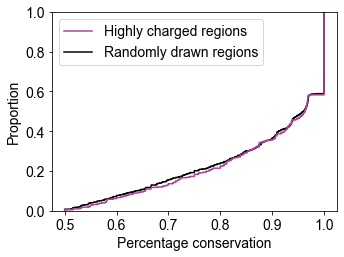

In [45]:
plt.figure(figsize=(5,3.8))
bw = 0.5
sns.ecdfplot(data=df_hc, x='abs_cons', color='#AA4499', zorder=2)
sns.ecdfplot(data=df_random, x='abs_cons', color='black', zorder=1)
plt.legend(['Highly charged regions',
            'Randomly drawn regions'])
plt.xlabel('Percentage conservation')
plt.tight_layout()
plt.savefig('../../figures/plots/Figure3.4F.png', dpi=300)
plt.show()

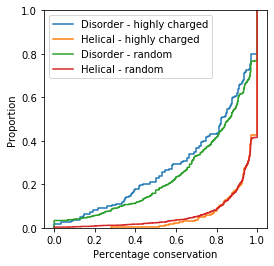

In [25]:
plt.figure(figsize=(4,4))
bw = 0.5
sns.ecdfplot(data=df_hc_matched[df_hc_matched.label == 'helix'], x='cons')
sns.ecdfplot(data=df_hc_matched[df_hc_matched.label == 'disordered'], x='cons')
sns.ecdfplot(data=df_random_matched[df_random_matched.label == 'helix'], x='cons')
sns.ecdfplot(data=df_random_matched[df_random_matched.label == 'disordered'], x='cons')
plt.legend(['Disorder - highly charged', 'Helical - highly charged',
            'Disorder - random', 'Helical - random'])
plt.xlabel('Percentage conservation')
plt.show()

## Spot checking outliers

In [26]:
def prediction_viewer(orf, left_bound):
    fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'
    row = df_hc[(df_hc.orf == orf) & (df_hc['left.bound'] == left_bound)].iloc[0]
    orf = row['orf']  
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    sc_label = row['label']

    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)

    tmpdf = pd.DataFrame(columns=['seq'])
    for seq in region_msa:
        s = crutil.remove_gaps(seq.seq)
        if len(s) >= 25:
            tmpdf = tmpdf.append({'seq': s}, ignore_index=True)

    for aa in states:
        tmpdf['freq_'+aa] = tmpdf.apply(lambda r: append_percent_aa(r, aa), axis=1)
    featurecol = []
    for aa in states:
        featurecol.append('freq_'+aa)
    X = tmpdf[featurecol]
    y = logreg.predict(X).tolist()
    for index,row in tmpdf.iterrows():
        print(row['seq'], y[index])
        

In [27]:
df_hc[(df_hc.label == 'disordered') & (df_hc.cons < 0.8)].sort_values(by='cons')

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2,uni_id,orf_label,label,cons,abs_cons
761,YPR091C,NVJ2,771,34,79,NLKSASKKELDHDTADEIDEKTRLLARDIDPEFKARKLEEQLGVKV,46,0.003953,0.478261,0.108872,0.254938,Q06833,verified,disordered,-1.000000,1.000000
592,YMR294W,JNM1,374,17,74,LIGIDNEESQEIFENEVKEDGQQEEQEEASSRKDGLIVEPGRDVES...,58,0.055862,0.431034,0.083886,0.245618,P36224,verified,disordered,-1.000000,1.000000
513,YLR398C,SKI2,1288,223,282,KQLNEIDNELDIRIEANEAKLKEEEKSAKSISEEIMEEATEETTAD...,60,0.138889,0.450000,0.077437,0.254479,P35207,verified,disordered,-1.000000,1.000000
382,YJL098W,SAP185,1059,754,803,WIAYTEDVLEDLKEKYNAILGDIAEEGDMLQDEEEDAVYDKGERTM...,50,0.160952,0.420000,0.087568,0.337573,P40856,verified,disordered,-0.972222,0.972222
385,YJL112W,MDV1,715,279,329,LLLEDNLKQIDDRLDFLEEYGLEVIEANSDENAEDDGMSERKALKN...,51,0.089127,0.431373,0.079451,0.255230,P47025,verified,disordered,-0.875000,0.875000
584,YMR235C,RNA1,408,340,406,DLLQSKFDDLEVDDFEEVDSEDEEGEDEEDEDEDEKLEEIETERLE...,67,0.306152,0.611940,0.125578,0.406743,P11745,verified,disordered,-0.750000,0.750000
14,YAR003W,SWD1,427,348,405,SALAPDFEEVEENVDYLEKEDEFDEVDEAEQQQGLEQEEEIAIDLR...,58,0.214854,0.448276,0.084773,0.322094,P39706,verified,disordered,-0.750000,0.750000
195,YER036C,ARB1,611,2,58,PVSASKAKRDAKKAEREAKKAAAGKTIRKLGRKKEAAAEESEVDAA...,57,0.043185,0.456140,0.089035,0.235717,P40024,verified,disordered,-0.612903,0.612903
333,YIL019W,FAF1,347,261,310,IVLSKVKKGQFRKIESTYKKDIERRIGGSIKARDKEKATKRERGLK...,50,0.105217,0.460000,0.037019,0.113306,P40546,verified,disordered,-0.576923,0.576923
73,YDL058W,USO1,1791,1074,1140,NKISELTKTREELEAELAAYKNLKNELETKLETSEKALKEVKENEE...,67,0.012037,0.462687,0.038101,0.090771,P25386,verified,disordered,-0.555556,0.555556


In [28]:
prediction_viewer('YDL058W', 1074)

TSAASFNRAHGLPPAEAIEPVVEVDERNPGPRAGVPPPPKALGGARPLV disordered
AEVSDLKKTIETLQSELDSSNEQNATEVS disordered
SDLASSEKDLASKTKDVSAKDTEIEKLKSELETANSKLASTAKEVEILTSELKAAKSDACDSETKIKAVESELVEQKSKVEHLNAELA disordered
EKVESIEKALESEKSSNKSLSEEKKLAEEKLEKLGNDLQQHQSSHESVVQEKTALTKKIE helix
DPSQEHKNVLVLSASSTVPPDQQIEEEISNGKEPDSQAVVRELEEKLAQTTKHLL disordered
SQKKKLENELSSLKQKHSDFSNQSETLTRELSDLKSSHEQLLGEKIIHDSAKAELDSQIASLNAKIAEFEASQAADKKDSD disordered
EEKRALENEKSELQKRWEEEKQKLEQEKDAQIKEYE helix
DENKTLKQQVEKIKDSSASAENQKSAVLSEFAQLREEKENKIS disordered
AANLELRNQIQNMQKKYDETVAKYKEEIENLKRQHTVEIELLKNNLNISEGQQSELESKLGKANEEIVKLAKTVEEKSACFK helix
EEKTGLEGQIASLSTEVAKLTEDMEVSSKAVKYELEELKKENERLKAELDASSELVAAKGEELNQNEQ helix
SRVQELREEISVLRSNLQDSEETHKLEISAYTDELDILKTDHSSVLAEYEHLKELYEKAVEGRSSQEADPSVSSNKEQIAKIIEDKETELKTSSKRVK disordered
EEKNKLKKQVEELEAKISSLKEDHESKSLSGVQEKESLTKELQVAKEQLKKLQKEVSTKESQVLEKSKELEEATKLSDSKAT helix
CENEKLKKDLEDIDNSKENAEAKQKSVEEELSNFKTKHSKVREELEKSLDAKTGEYNDAIEKLKNKDISIASLKETHSKKVS disordered
TKNKNLQEKLDSTVST

In [29]:
prediction_viewer('YER164W', 911)

LGGEEFLNQFAVQDVKADMTSWEDIIPADDRERALAKLEEEAKEAKAKAQADSTR helix
LGGEEFLKQFEVTDFKADVTWDDIIPEDDRKRIKEEEDERRNDEYLQQQMAASS disordered
MGGEEFLKQFEVTDYKADVSWDDIIPLTEREKFEEEDRLREEEEALKQEIELSS helix
MGGEEFLKQFEVTDYKAEDLNWDDIIPEEEMERIEEEERMLAAQRAKEEERERRE helix
SGGIDWDNWMQVTDVKVDDLALDWDQIIPAEQLAAIKAEENRKKEEEYLAKTIEENA helix
SGGIDWDNFMQITDVKVDDINLDWDQIIPAEKLAEIKAEEEKKQHEDYLAQVAAESA helix
DGGEEFLRAFEYVDIKVDDLSWDDIIPKEQLEEIKAEEKKKADERYLAEVIEQNR helix
LGGEEFLKQFEVTDYKADVSWDDIIPASELQRIKEEEQKRKNDEFLQEQIKMNS helix
LGGEEFLKQFEVTDYKADVDWDDIIPANELAKIKADDLRRKDEEYVKEQMDLMN helix
LGGEEFLKQFEVTDYKADMTWDDIIPADELAKIKEEEQKRKDDEYLQEQIAMFA helix
LGGEEFLKQFEVTDYKADVSWDDIIPPEELARLKDEEKKRRDELYLQEQIQMSS helix
LGGEEFLRQFEVTDYKANVEWDDIIPEEELQKIKEEEKKRKDEIFLQEQIEMSS helix
LGGEEFLKQFEVTDYKADVDWDDIIPEDELKKLKEEEKKREDDAYLQQQIQMYS helix
LGGEEFLKQFEVTDYKADVDWDDIIPEDELKKLKEEEKKRQDEEYLKEQIEMFS helix
LGGEEFLKQFEVTDYKADVDWDDIIPEEELKKLKEDEKKRQDEQYLQQQIEMYS helix
LGGEEFLRQFEVTDYKADVDWDDIIPEEDLKRIKEEEEKRKEETFLQEQIEMSS helix
LGGEEFLKQF

In [30]:
prediction_viewer('YGR285C', 228)

SWRSFEYADKDVAEGADSRDEKRHQEKKNKAERDRKKKEDNTRRRTLVDQGLALDPRIKQFRAAEKAAREAKRRGGAGVPAQLDPAEKAEQEKKAKELAEAEAAAAAAKEAADKADREVQKKAKAAAAKEVKKNKKAISNAVS disordered
SWRTFEYLDKDIPDDSDNRDQKRYQEKKNKADRAKRKTEDTARLRKLVDDVLAQDPRIKMFKQAEKEAKEKAKWERERGAREAAEAAKRAEEEEAARKQKEEDEAKLAAVDKKAQKEKAKKESKKNKKTIKNALK disordered
SWRSFEYLDKDIPDDGESRDNKRFQEKKNRSERQKNKARDNARLRNLVDTALASDPRIKLFKEQEKAAKAARKWEREAGAREAAAAAQKKKEEEERRAAEEAAAKASAAAANKKAKEDKKKAQKRDKKVVKNALK disordered
SWRSFEYLDEDVPDDSESRDQRRHTERKNLNTRKKRKAEDNARLRKLLDDCSAADERIKKFRQEANAAKNKKRLEKEAAEKKAAEEAAAKKAAEEAAAKEAEEKAKADREASKKAKEAAKNAVKKNKRVLRGSVK disordered
SWRSFEYLDEDVPDDGESRDHKRHVERKNANSRKKKKAEDNARLRKLLDDASAGDERIKRFRQEANAAKNKKKLEKEAAEKKAAEEAQAKKEAEEKAKAEAEAAAKADREAGKKAKEAAKNALKKNKRVLKGSVK disordered
SWRTFEYLDEDVPDDNENRDQKRHMEKKNANARRKRKTEDTTRLRHLVDDCAAGDERIKKFRKAARADKDRKRLEKEAEIKRLAEEKEKARLEEEQRKKDAEEAAKAEREQNKKAKEAAKNAAKKNKRVLKGSVK disordered
SWRSFEYLDEDVPDDSDNRDNKRHTERKNKTARQKRKTEDTARLRKSVDDCLTSDPRVKVFKEAERMAKEQRKWEREADARKASEQAKKAKEEEERRRKEEEERSKEERS